## A Time Series Analysis of Washington D.C. Capital Bikeshare Usage to Forecast Future Rentals 
#### Marissa Eppes & Kyle Hayes

**SUMMARY**: In order to determine whether D.C. Bikeshare has a sufficient number of bicycles in stock for the upcoming 12 months, we obtained data on the number of times per month that customers have checked bicycles out between September, 2010 and July, 2019. We obtained this data from https://s3.amazonaws.com/capitalbikeshare-data/index.html. We grouped the data by month in order to remove excessive day-by-day variations within the time frame and tuned a Seasonal ARIMA (SARIMA) time series model to predict the number of monthly rentals, along with prediction intervals, for the next 12 month. 

We then broke down the data between member rentals and casual rentals and constructed separate SARIMA models for each to gain a further understanding of how membership comes into play in an attempt to better understand the industry.

In [1]:
# Import all necessary libraries.

import warnings
import plots as p
import functions as f
import data_testing as dt
import data_prep as dp
import pandas as pd
import itertools
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

First, we will download the cleaned dataset. Raw data was processed to create a clean dataset using dp.full_clean().

In [2]:
bike_df = f.import_cleaned()

In [3]:
bike_df.head()

,count
date_of_trip,
2010-09-30,4002
2010-10-31,35957
2010-11-30,47390
2010-12-31,28248
2011-01-31,37503


Now, we will plot an initial time series graph to ensure that the data is functional.

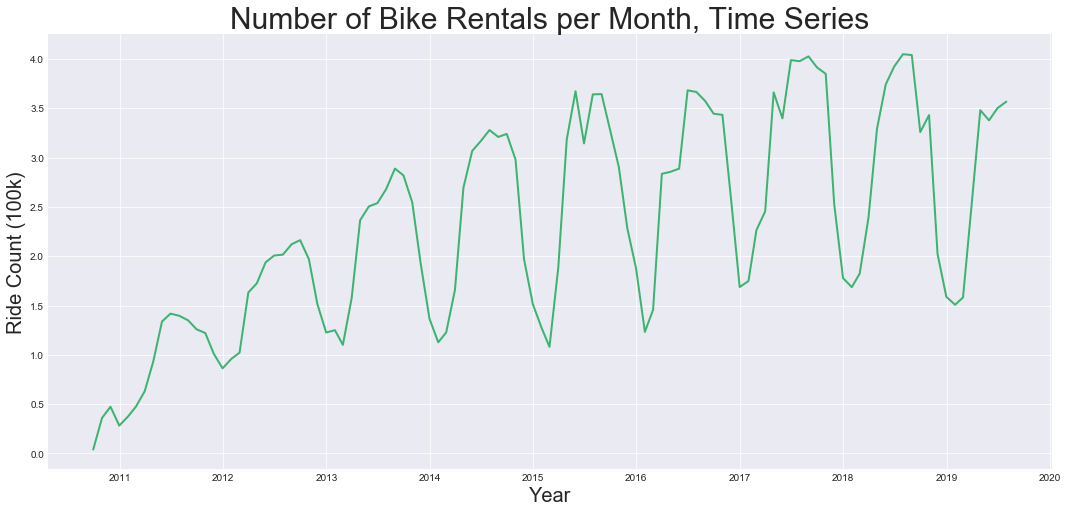

In [4]:
p.initial_plot(bike_df)

Before moving forward, we will divide the data into a 75% training dataset and a 25% testing dataset. We will then graph both to make sure that the split is functional.

In [5]:
train_df, test_df = f.train_split(bike_df)

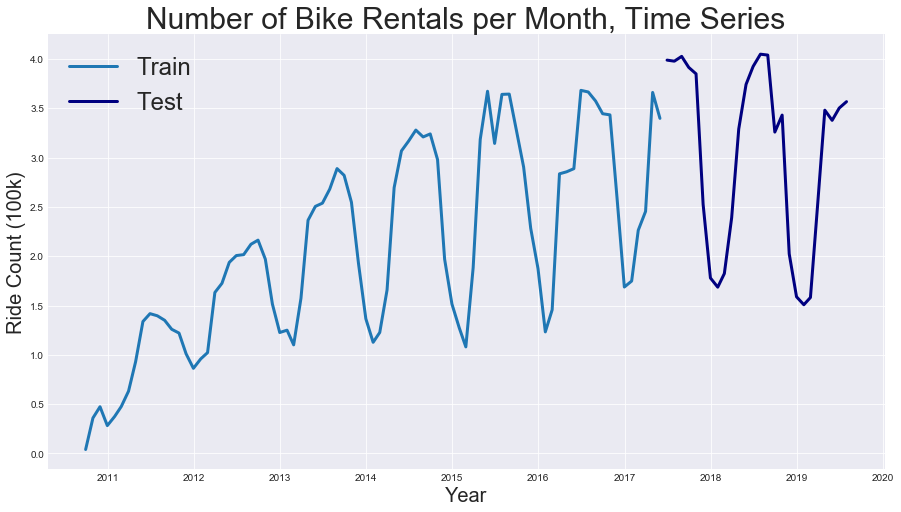

In [6]:
p.split_plot(train_df, test_df)

In order to determine whether there is either a trend or a seasonal fluctuation, we will create a decomposition.

<Figure size 432x288 with 0 Axes>

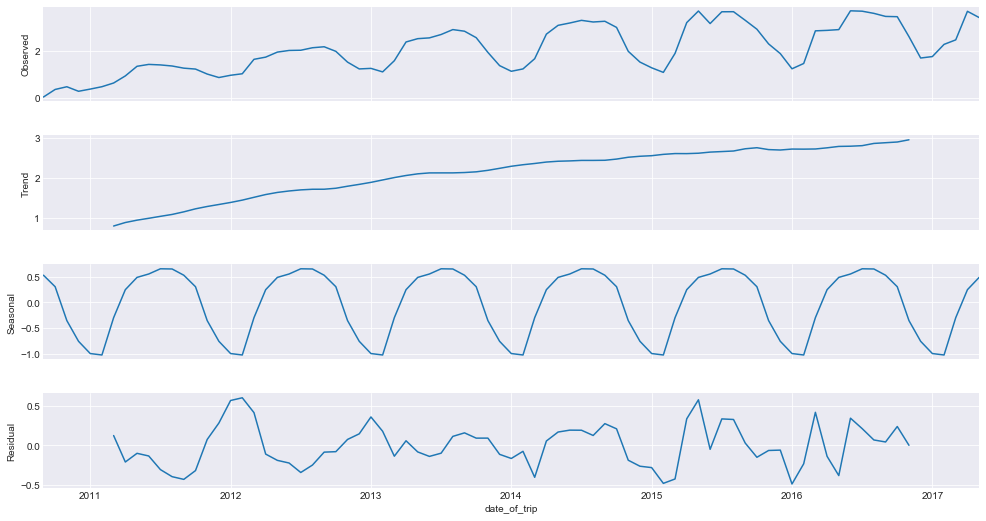

In [7]:
p.decomposition(train_df)

This decomposition suggests the presence not only of overall trends, but of 12-month seasonal trends as well. In order to create our model, we will need to make sure that we create enough regular and seasonal differences in our model to make our data stationary.

## Differencing

We will now perform a preliminary Dickey-Fuller test on our model, in order to prove that our time-series requires differencing to become stationary. This test will take as its null hypothesis that the time-series is not stationary, and will attempt to disprove this null hypothesis. It will also graph the rolling mean and the rolling standard deviation of the time-series.

We will be looking at both the p-value of the test (defining any values above 0.05 as statistically significant) to determine whether the time-series is stationary. We will also be assessing the graphs of the rolling mean and the rolling standard deviations to see if they are stationary.

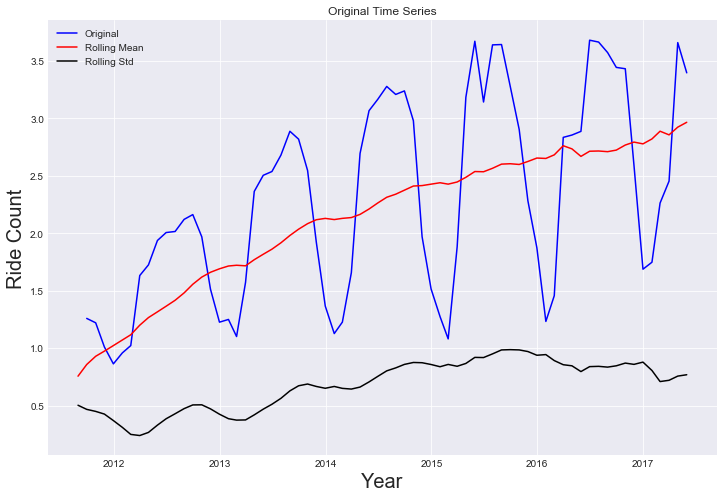

Results of Dickey-Fuller Test:
Test Statistic                 -4.065344
p-value                         0.001104
#Lags Used                     11.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64


In [8]:
dt.stationarity_test(train_df)

Although the p-value indicates that the time-series is stationary, the graph of the rolling mean shows a clear trend. We will now try adding a difference of one month.

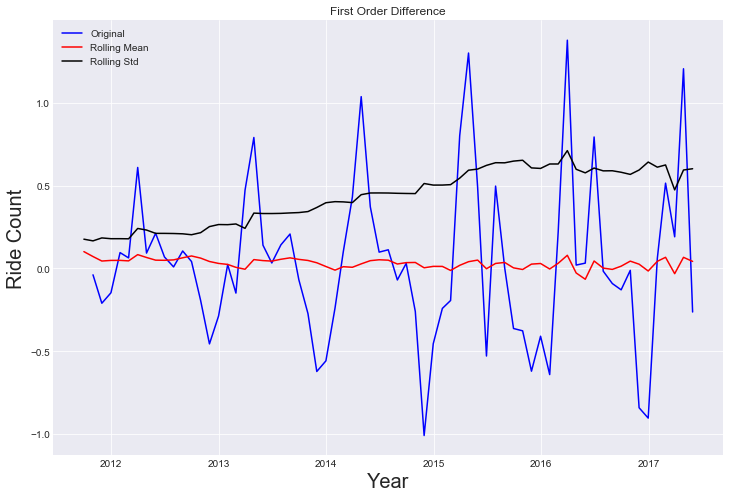

Results of Dickey-Fuller Test:
Test Statistic                 -3.316431
p-value                         0.014160
#Lags Used                     12.000000
Number of Observations Used    67.000000
Critical Value (1%)            -3.531955
Critical Value (5%)            -2.905755
Critical Value (10%)           -2.590357
dtype: float64


In [9]:
dt.stationarity_test(train_df, diff=True)

Although the p-value has increased (potentially due to a slight increase throughout the graph in the rolling standard deviation), there is still less than a 5% chance that the time-series with one difference is not stationary. In addition, the rolling mean has become visibly more stationary. This indicates that we can remove the overall trend by including a single one-month difference in our ARIMA model. Although this could potentially be improved with another one-month difference, since our SARIMA model will likely require a 12-month difference, we will only include a single regular one-month difference at this point.

We will now use the Dickey-Fuller test to determine how many one-month differences our SARIMA model will require. The first test will assess our original data with a 12-month difference added.

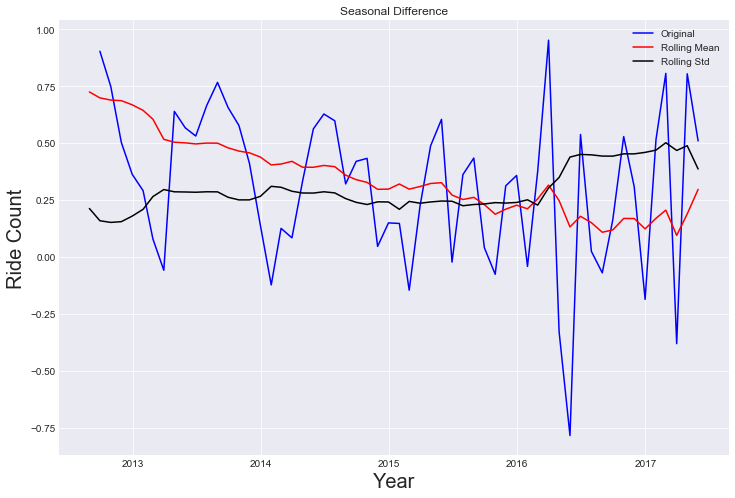

Results of Dickey-Fuller Test:
Test Statistic                 -1.953684
p-value                         0.307243
#Lags Used                      9.000000
Number of Observations Used    59.000000
Critical Value (1%)            -3.546395
Critical Value (5%)            -2.911939
Critical Value (10%)           -2.593652
dtype: float64


In [10]:
dt.stationarity_test(train_df, s_diff=True)

The p-value is far above our 5% cut-off rate, indicating that we cannot disprove the null hypothesis. This indicates that even with a 12-month difference, our seasonal data is not stationary. We will now try differencing our original data by one month, and then adding a 12-month difference to this data.

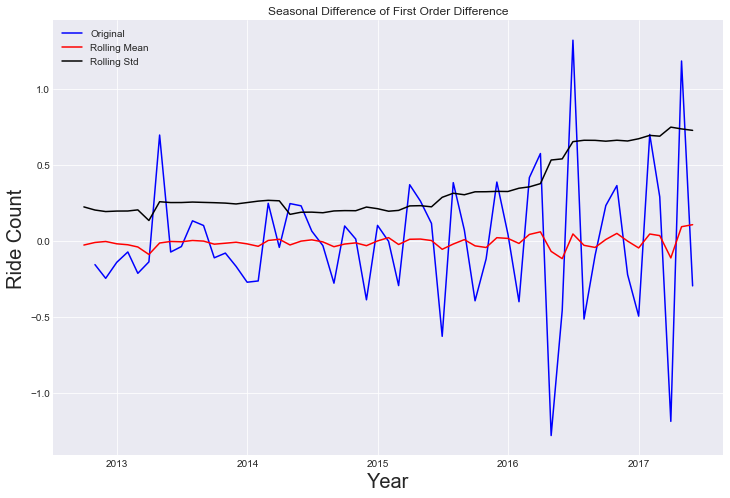

Results of Dickey-Fuller Test:
Test Statistic                -6.093700e+00
p-value                        1.021998e-07
#Lags Used                     8.000000e+00
Number of Observations Used    5.900000e+01
Critical Value (1%)           -3.546395e+00
Critical Value (5%)           -2.911939e+00
Critical Value (10%)          -2.593652e+00
dtype: float64


In [11]:
dt.stationarity_test(train_df, diff=True, s_diff=True)

Both the graph and the p-value indicate that when we difference our data by one month, and then add a 12-month seasonal difference, this removes the seasonal fluxuations. We will therefore move forward with the assumption that our ARIMA model requires one difference, and that our SARIMA model with a 12-month seasonal difference also requires a one-month difference.

## Autoregressions (ARs) and Moving Averages (MAs)

We will now determine whether our ARIMA or SARIMA models require any ARs or MAs. We will do this by creating autocorrelation functions (ACFs) and partial-autocorrelation functions (PACFs) for our data.

The ACF and PACF will relate to our data with a one-month difference.

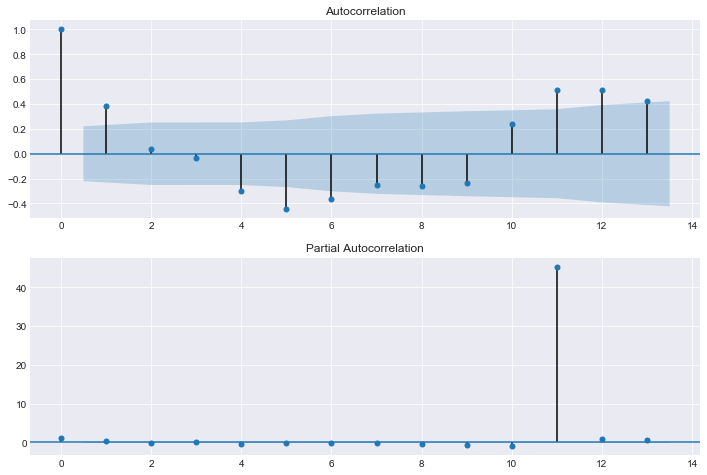

In [12]:
first = f.order_difference(train_df, diff=True, s_diff=False)
p.acf_pacf(first)

Since the first lag of the PACF seems positive, this indicates that our ARIMA model should contain at least one AR. However, since the first lag of the ACF contains a somewhat sharp cutoff, it may also require at least one MA.

In addition, since our seasonal cycle is roughly 12 months, we can look at the 11-13 month lag in the ACF to determine whether our SARIMA model will require at least one seasonal AR. However, the fact that the PACF contains a very sharp drop at the twelve-month lag, this indicates that the model may also require a seasonal MA.

Since it can be difficult to determine the optimal number of ARs and MAs, we will test a number of models, and determine the Means Squared Error (MSE) for each model.

Each model will have a different number of ARs and MAs for its ARIMA and SARIMA parameters. For the ARIMA model, in order to keep multiple ARs and MAs from cancelling out each other, and to avoid overfitting, each ARIMA model we test will have no more than two of each. The ARIMA models tested will be as follows:

(1, 1, 0), (2, 1, 0), (1, 1, 1), (2, 1, 1), (1, 1, 2)


For the SARIMA model, in order to avoid overfitting, we will use no more than two combined SARs and SMAs. The SARIMA models tested will be as follows:

(1, 1, 0, 12), (2, 1, 0, 12), (1, 1, 1, 12)

(1, 1, 0), (1, 1, 0, 12):
Training MSE:  1.11e+09
(1, 1, 0), (2, 1, 0, 12):
Training MSE:  1.11e+09
(1, 1, 0), (1, 1, 1, 12):
Training MSE:  1.11e+09
(2, 1, 0), (1, 1, 0, 12):
Training MSE:  1.02e+09
(2, 1, 0), (2, 1, 0, 12):
Training MSE:  1.02e+09
(2, 1, 0), (1, 1, 1, 12):
Training MSE:  1.01e+09
(1, 1, 1), (1, 1, 0, 12):
Training MSE:  1.07e+09
(1, 1, 1), (2, 1, 0, 12):
Training MSE:  1.08e+09
(1, 1, 1), (1, 1, 1, 12):
Training MSE:  1.11e+09
(2, 1, 1), (1, 1, 0, 12):
Training MSE:  9.92e+08
(2, 1, 1), (2, 1, 0, 12):
Training MSE:  9.89e+08
(2, 1, 1), (1, 1, 1, 12):
Training MSE:  1.00e+09
(1, 1, 2), (1, 1, 0, 12):
Training MSE:  1.06e+09
(1, 1, 2), (2, 1, 0, 12):
Training MSE:  1.06e+09
(1, 1, 2), (1, 1, 1, 12):
Training MSE:  1.08e+09
Best MSE: 9.89e+08
Best Model: (2, 1, 1), (2, 1, 0, 12)


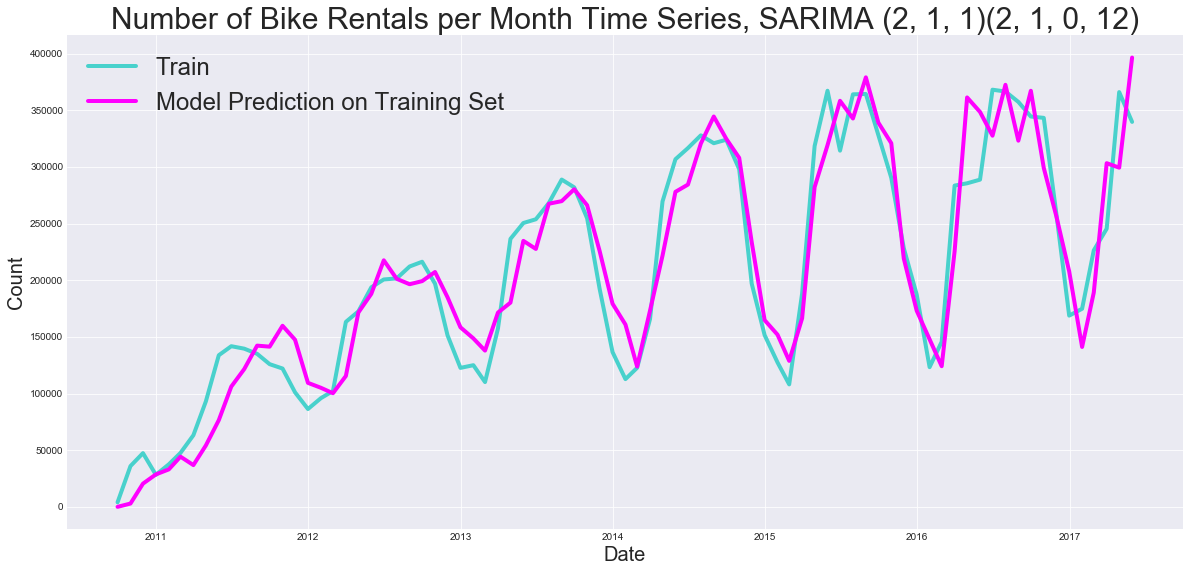

In [15]:
orders = [(1, 1, 0), (2, 1, 0), (1, 1, 1), (2, 1, 1), (1, 1, 2)]
s_orders = [(1, 1, 0, 12), (2, 1, 0, 12), (1, 1, 1, 12)]
dt.sarima(train_df, orders, s_orders)

Based on this analysis, we're able to determine that a model with a first order of regular differencing, three regular ARs, a twelve-month seasonal differencing for its first order of regular differencing, and one seasonal AR produce the smallest MSE.

Before we accept this result, we want to first check the model summary, to ensure that each AR and MA is statistically significant, and remove any that are not statistically significant. This will prevent 

In [16]:
best = sm.tsa.statespace.SARIMAX(train_df['count'], trend='n',
                                 order=(1, 1, 1), seasonal_order=(2, 1, 0, 12)).fit()
best.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              count   No. Observations:                   81
Model:             SARIMAX(1, 1, 1)x(2, 1, 0, 12)   Log Likelihood                -803.984
Date:                            Sun, 03 May 2020   AIC                           1617.968
Time:                                    17:53:28   BIC                           1629.066
Sample:                                09-30-2010   HQIC                          1622.365
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3196      0.179      1.784      0.074      -0.031       0.671
ma.L1         -0.8961      0.102     -8.748      0.000      -1.097      -0.695
ar.S.L12      -0.2832      0.194     -1.457      0.145      -0.664       0.098
ar.S.L24       0.0403      0.260      0.155      0.877      -0.470       0.551
sigma2      1.442e+09   5.93e-11   2.43e+19      0.000    1.44e+09    1.44e+09
===================================================================================
Ljung-Box (Q):                       68.83   Jarque-Bera (JB):                 0.05
Prob(Q):                              0.00   Prob(JB):                         0.98
Heteroskedasticity (H):               3.18   Skew:                             0.03
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.46e+35. Standard errors may be unstable.
"""

Based on this summary, we can determine that the first two regular autoregressions are statistically significant. However, the moving average, and the seasonal autoregressions are not statistically significant, indicating that our model would be improved by removing them. For this reason, we will keep two autoregressions, and remove the rest of the autoregressions and moving averages.

## Initial Modeling Results

The (2, 1, 0), (0, 1, 0, 12) model has the lowest MSE for the training data while maintaining statistical significance for each SARIMA regulator, indicating that this is the model that we should use. Based on this result, we will use the model to determine the MSE for the test dataset. Then, we will create a 12-month forecast of the original dataset, including an 80% prediction interval.

First, we will take a look at residual normality to make sure this model is valid. 

In [17]:
best = sm.tsa.statespace.SARIMAX(train_df['count'], trend='n',
                                 order=(2, 1, 1), seasonal_order=(2, 1, 0, 12)).fit()

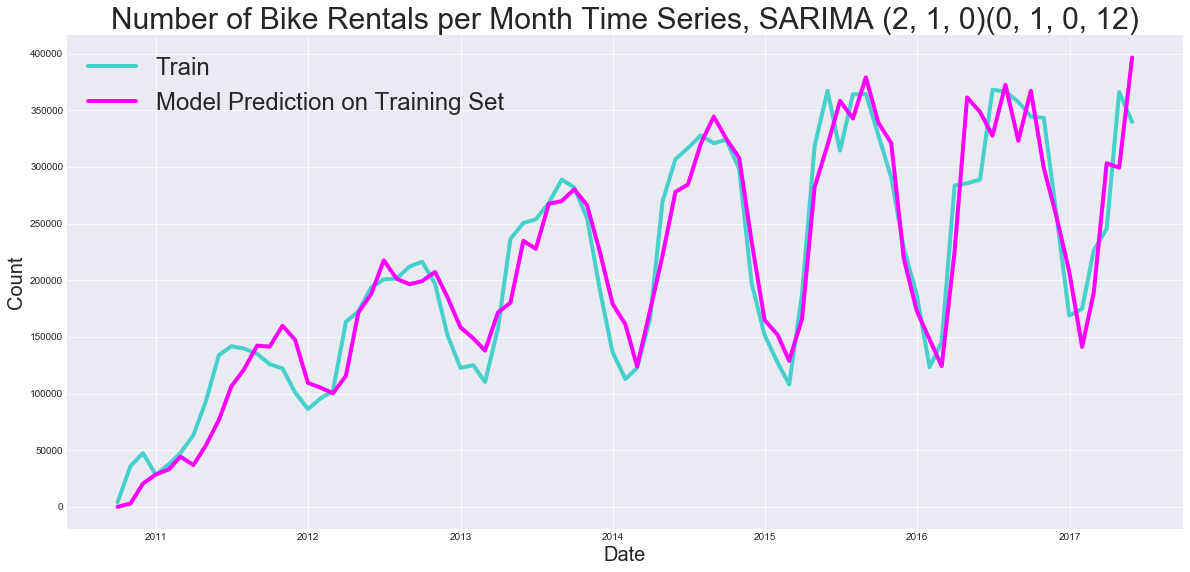

In [19]:
p.prediction_plot(best, train_df, orders=[(2, 1, 0),(0, 1, 0, 12)], test=False, var='count')

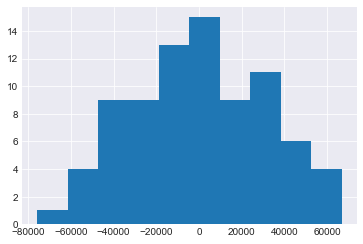

In [20]:
best.resid.hist()

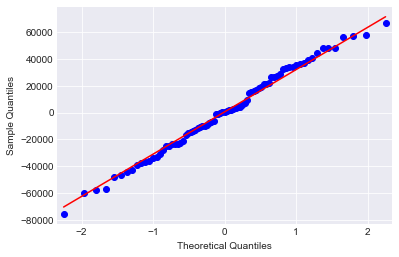

In [21]:
qqplot(best.resid, line='s');

Based on this, the residuals appear normally distributed. Next, we will graph both the training and test data, and we will determine the MSE for the test data.

Training MSE:  9.89e+08
Testing MSE:  2.56e+09


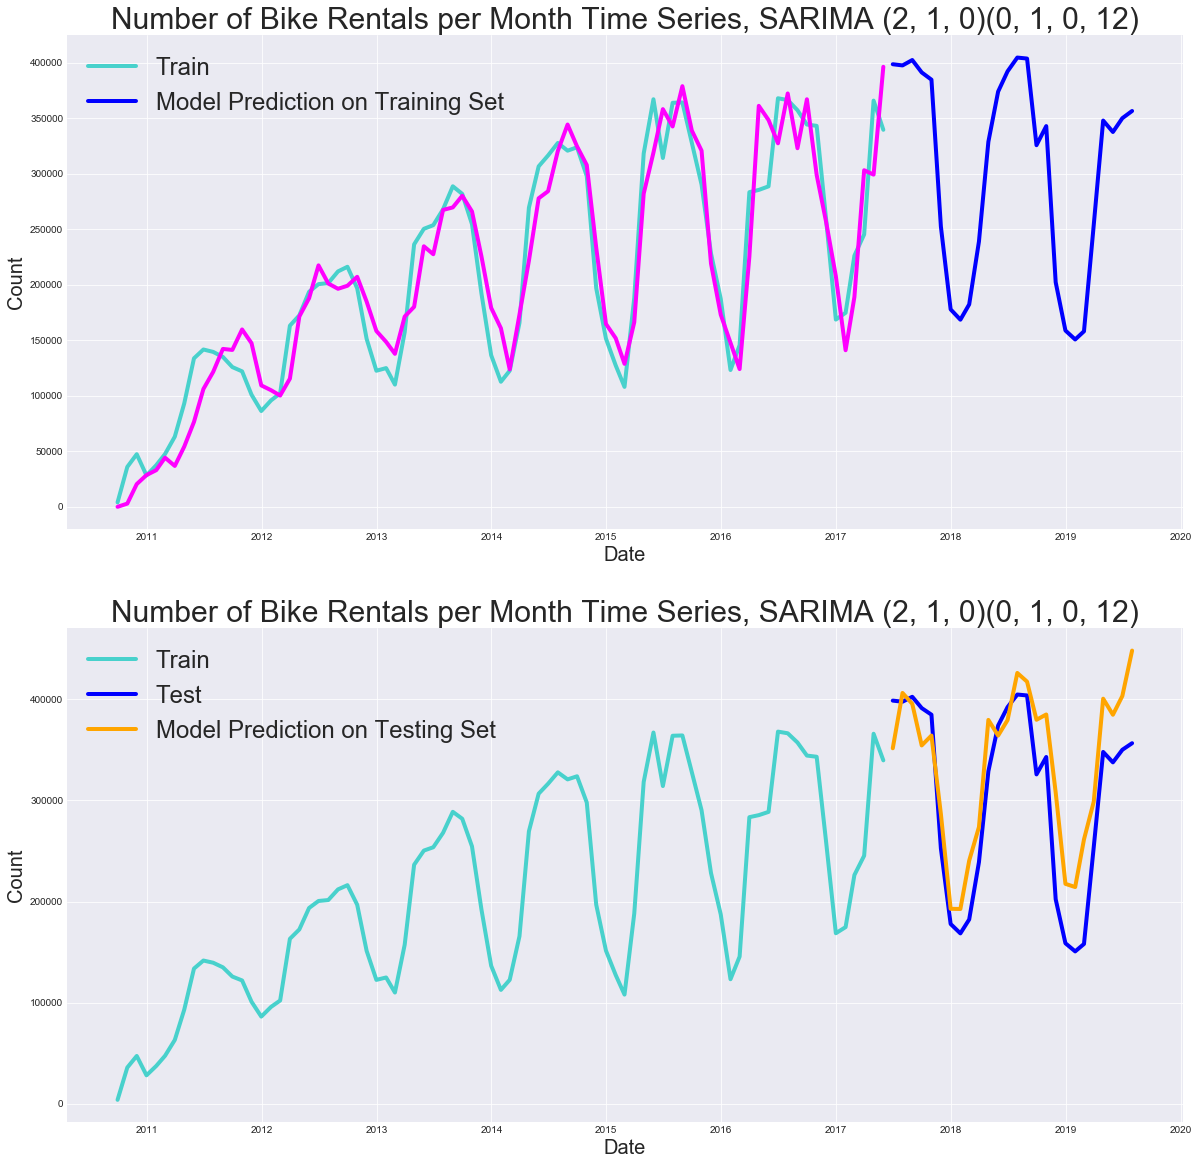

In [23]:
dt.compare_mse(best, bike_df, test=True, return_val=False)
p.prediction_plot(best, bike_df, orders=[(2, 1, 0),(0, 1, 0, 12)], test=True)

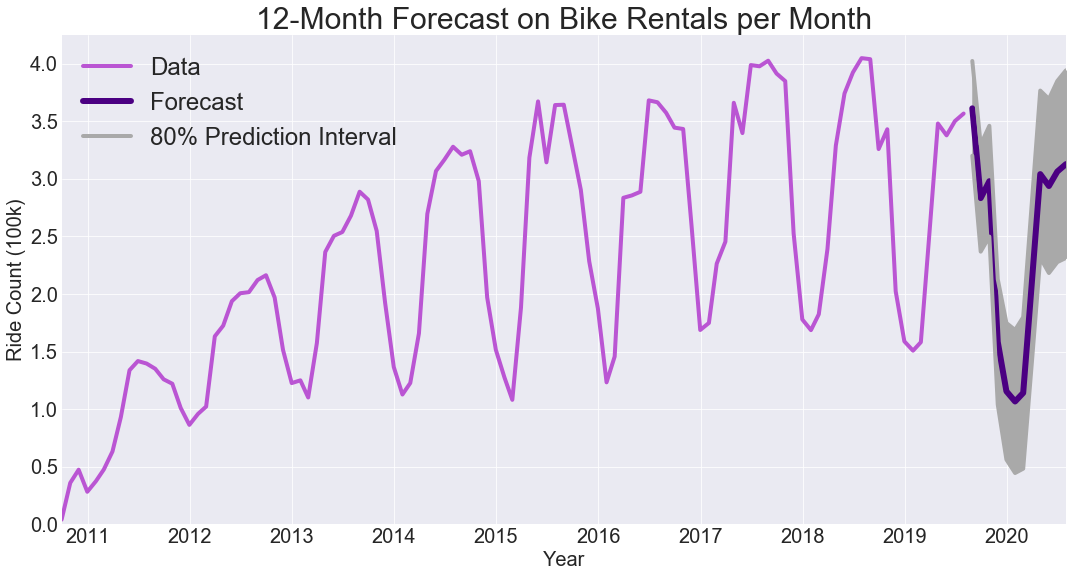

In [24]:
best = sm.tsa.statespace.SARIMAX(bike_df['count'], trend='n', order=(2, 1, 0), seasonal_order=(0, 1, 0, 12)).fit()
p.forecast_plot(best, bike_df, 12)

From this, we can see that the MSE increases quite a bit. In addition, we can also see from our 80% prediction interval in our test dataset that 

From this, we can see that there is still a lot of variance in the prediction interval. A logical next step is to consider trends in rentals grouped as either casual or member rentals. From this point on, we will divide the dataset into 'Member' and 'Casual' (one-time bicycle renters).

## Member/Casual Rental Breakdown

The following functions and lines of code re-clean the data, this time breaking the datasets down according to member vs. casual rentals per month. We will now download data grouped by membership, graph it, and split it into the 75%-25% train-test group.

In [25]:
bike_rental_type = f.master_breakdown()

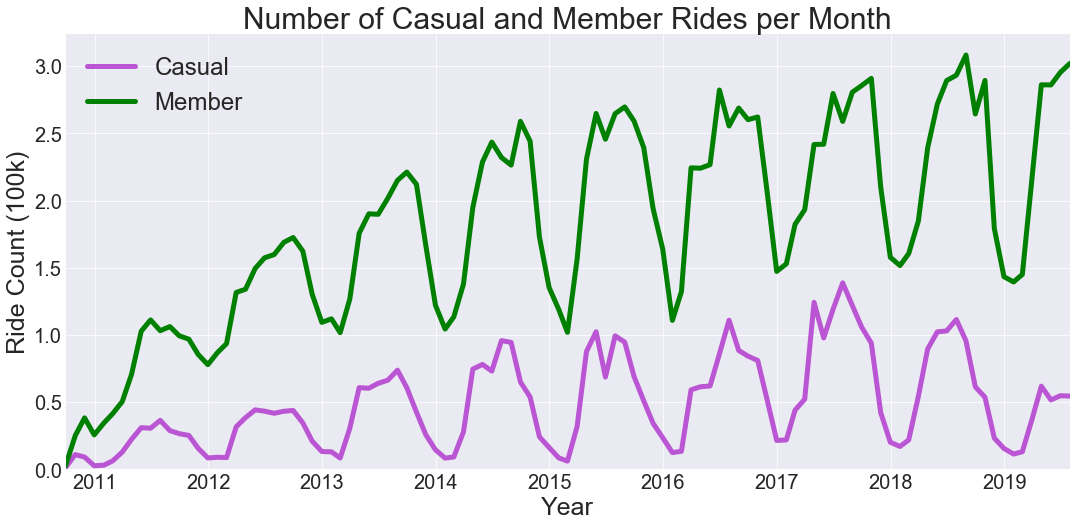

In [26]:
p.initial_breakdown_graph(bike_rental_type)

In [27]:
breakdown_train, breakdown_test = f.train_split(
    bike_rental_type, train_percent=.75)

In order to find the best models for each, we need to first determine the ARIMA and SARIMA parameters for each data group.

## Member dataset

We will start with the "Member" dataset. We will first determine the number of orders of differencing it requires.

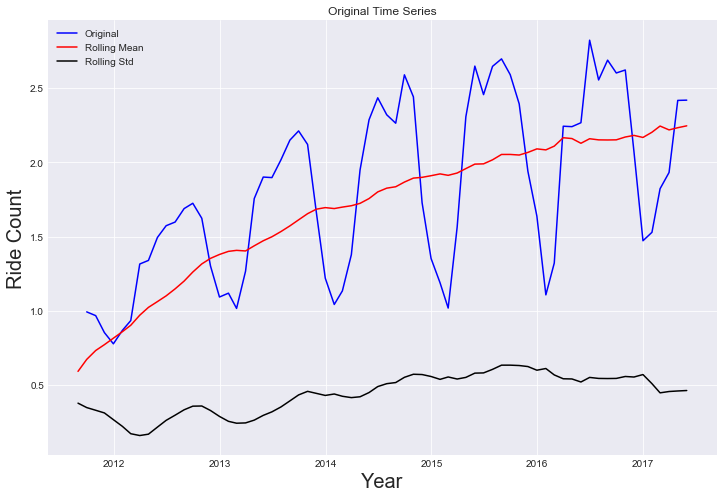

Results of Dickey-Fuller Test:
Test Statistic                 -4.835134
p-value                         0.000047
#Lags Used                     11.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64


In [28]:
dt.stationarity_test(breakdown_train, var='member')

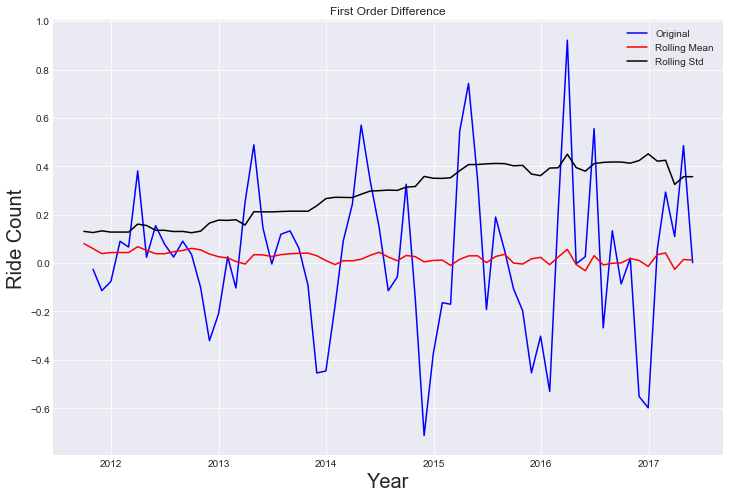

Results of Dickey-Fuller Test:
Test Statistic                 -3.395180
p-value                         0.011124
#Lags Used                     11.000000
Number of Observations Used    68.000000
Critical Value (1%)            -3.530399
Critical Value (5%)            -2.905087
Critical Value (10%)           -2.590001
dtype: float64


In [29]:
dt.stationarity_test(breakdown_train, var='member', diff=True)

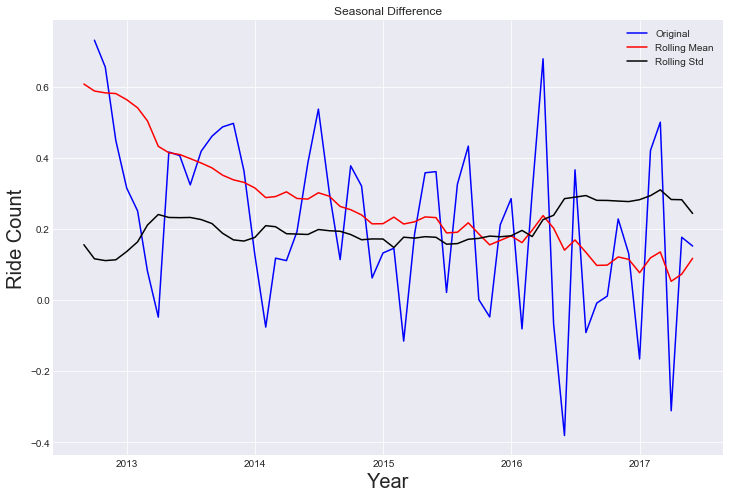

Results of Dickey-Fuller Test:
Test Statistic                 -1.810303
p-value                         0.375359
#Lags Used                      9.000000
Number of Observations Used    59.000000
Critical Value (1%)            -3.546395
Critical Value (5%)            -2.911939
Critical Value (10%)           -2.593652
dtype: float64


In [30]:
dt.stationarity_test(breakdown_train, var='member', s_diff=True)

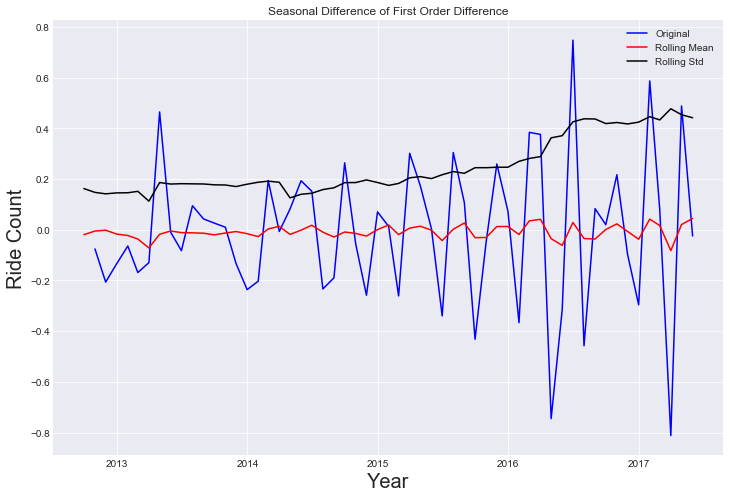

Results of Dickey-Fuller Test:
Test Statistic                -6.284988e+00
p-value                        3.716892e-08
#Lags Used                     8.000000e+00
Number of Observations Used    5.900000e+01
Critical Value (1%)           -3.546395e+00
Critical Value (5%)           -2.911939e+00
Critical Value (10%)          -2.593652e+00
dtype: float64


In [31]:
dt.stationarity_test(breakdown_train, var='member', s_diff=True, diff=True)

Like the prior model, this indicates that the "Members" dataset requires one order of regular differencing, and one order of 12-month seasonal differencing following this differencing.

We will now look at the PACF and ACF.

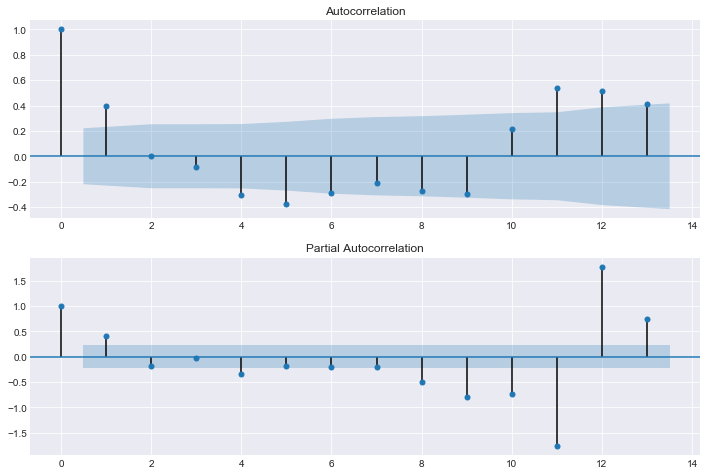

In [32]:
first = f.order_difference(breakdown_train, var='member', diff=True, s_diff=False)
p.acf_pacf(first, var='member')

As with the prior analysis, this dataset has a positive first difference in its PACF, indicating it will require at least one AR. In addition, the positive autocorrelation surrounding the 12-month seasonal difference indicates that it will require at least one SAR as well.

In order to verify the best model, we will use the prior function to determine the optimal ARIMA and SARIMA parameters. We will test the same ARIMA/SARIMA combinations as before.

(1, 1, 0), (1, 1, 0, 12):
Training MSE:  5.03e+08
(1, 1, 0), (2, 1, 0, 12):
Training MSE:  5.00e+08
(1, 1, 0), (1, 1, 1, 12):
Training MSE:  4.99e+08
(2, 1, 0), (1, 1, 0, 12):
Training MSE:  4.58e+08
(2, 1, 0), (2, 1, 0, 12):
Training MSE:  4.57e+08
(2, 1, 0), (1, 1, 1, 12):
Training MSE:  4.56e+08
(1, 1, 1), (1, 1, 0, 12):
Training MSE:  4.94e+08
(1, 1, 1), (2, 1, 0, 12):
Training MSE:  4.94e+08
(1, 1, 1), (1, 1, 1, 12):
Training MSE:  4.93e+08
(2, 1, 1), (1, 1, 0, 12):
Training MSE:  4.46e+08
(2, 1, 1), (2, 1, 0, 12):
Training MSE:  4.43e+08
(2, 1, 1), (1, 1, 1, 12):
Training MSE:  4.44e+08
(1, 1, 2), (1, 1, 0, 12):
Training MSE:  4.83e+08
(1, 1, 2), (2, 1, 0, 12):
Training MSE:  4.81e+08
(1, 1, 2), (1, 1, 1, 12):
Training MSE:  4.81e+08
Best MSE: 4.43e+08
Best Model: (2, 1, 1), (2, 1, 0, 12)


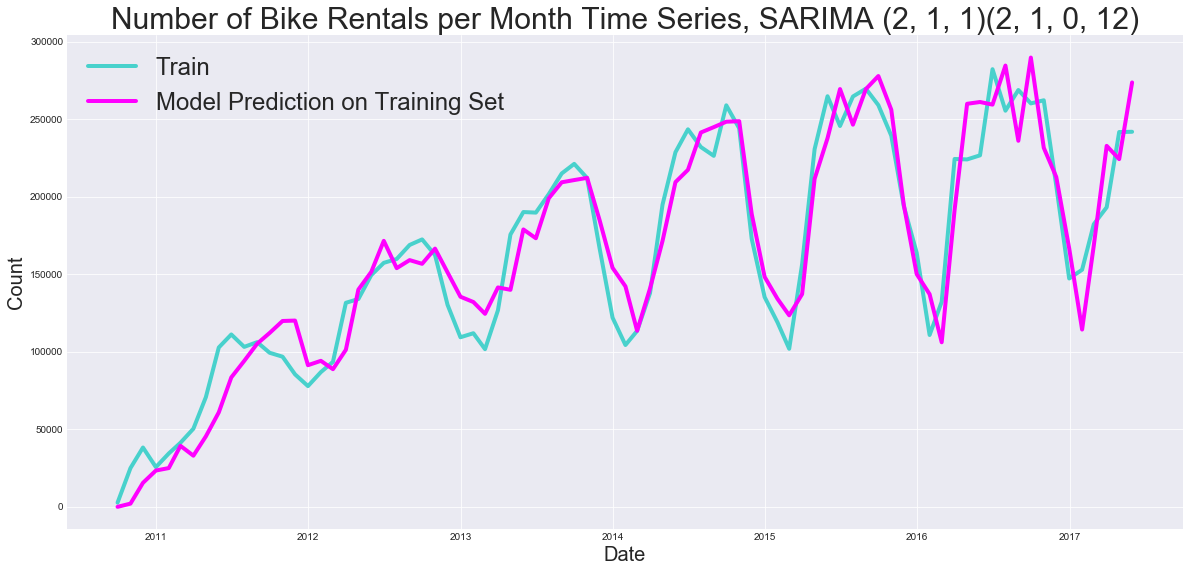

In [33]:
orders = [(1, 1, 0), (2, 1, 0), (1, 1, 1), (2, 1, 1), (1, 1, 2)]
s_orders = [(1, 1, 0, 12), (2, 1, 0, 12), (1, 1, 1, 12)]
dt.sarima(breakdown_train, orders, s_orders, var='member')

From this, we can determine that for the "Member" dataset, the SARIMA model with the parameters
(2, 1, 1) (2, 1, 0, 12) minimizes training MSE. We will now determine whether each regularization is statistically significant, and remove any regularizations that are not statistically significant.

In [34]:
best_m = sm.tsa.statespace.SARIMAX(breakdown_train['member'], trend='n',
                                   order=(2, 1, 1),
                                   seasonal_order=(2, 1, 0, 12)).fit()
best_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             member   No. Observations:                   81
Model:             SARIMAX(2, 1, 1)x(2, 1, 0, 12)   Log Likelihood                -774.463
Date:                            Sun, 03 May 2020   AIC                           1560.927
Time:                                    17:55:03   BIC                           1574.244
Sample:                                09-30-2010   HQIC                          1566.203
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5122      0.171     -3.000      0.003      -0.847      -0.178
ar.L2         -0.5749      0.100     -5.747      0.000      -0.771      -0.379
ma.L1          0.2139      0.228      0.937      0.349      -0.234       0.661
ar.S.L12      -0.1375      0.154     -0.891      0.373      -0.440       0.165
ar.S.L24      -0.1006      0.157     -0.640      0.522      -0.409       0.208
sigma2      4.501e+08   4.75e-11   9.48e+18      0.000     4.5e+08     4.5e+08
===================================================================================
Ljung-Box (Q):                       51.21   Jarque-Bera (JB):                 3.58
Prob(Q):                              0.11   Prob(JB):                         0.17
Heteroskedasticity (H):               2.04   Skew:                             0.12
Prob(H) (two-sided):                  0.09   Kurtosis:                         1.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.14e+34. Standard errors may be unstable.
"""

Based on this summary, we can tell that neither the moving average nor the seasonal auto-regressions are statistically significant. We will remove these.

In [35]:
best_m = sm.tsa.statespace.SARIMAX(breakdown_train['member'], trend='n',
                                   order=(2, 1, 0),
                                   seasonal_order=(0, 1, 0, 12)).fit()
best_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             member   No. Observations:                   81
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -775.270
Date:                            Sun, 03 May 2020   AIC                           1556.540
Time:                                    17:55:04   BIC                           1563.199
Sample:                                09-30-2010   HQIC                          1559.179
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4068      0.079     -5.136      0.000      -0.562      -0.252
ar.L2         -0.5807      0.081     -7.137      0.000      -0.740      -0.421
sigma2      4.456e+08   1.32e-11   3.37e+19      0.000    4.46e+08    4.46e+08
===================================================================================
Ljung-Box (Q):                       48.16   Jarque-Bera (JB):                 2.92
Prob(Q):                              0.18   Prob(JB):                         0.23
Heteroskedasticity (H):               1.76   Skew:                             0.04
Prob(H) (two-sided):                  0.18   Kurtosis:                         1.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.63e+35. Standard errors may be unstable.
"""

We will now test the "Members" dataset for normal distribution of residuals.

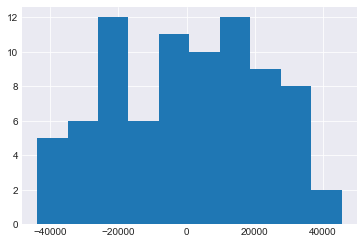

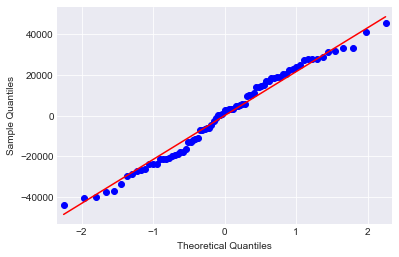

In [36]:
best_m = sm.tsa.statespace.SARIMAX(breakdown_train['member'], trend='n',
                                   order=(2, 1, 0),
                                   seasonal_order=(0, 1, 0, 12)).fit()
best_m.resid.hist()
qqplot(best_m.resid, line='s');

Based on this, although the "Member" residuals appear slightly less normally distributed than the prior dataset, they are still within an acceptable range. Next, we will graph both the "Member" training and test data, and we will determine the MSE for the test data. We will then graph the 12-month projection, including confidence interval.

Training MSE:  4.65e+08
Testing MSE:  5.90e+08


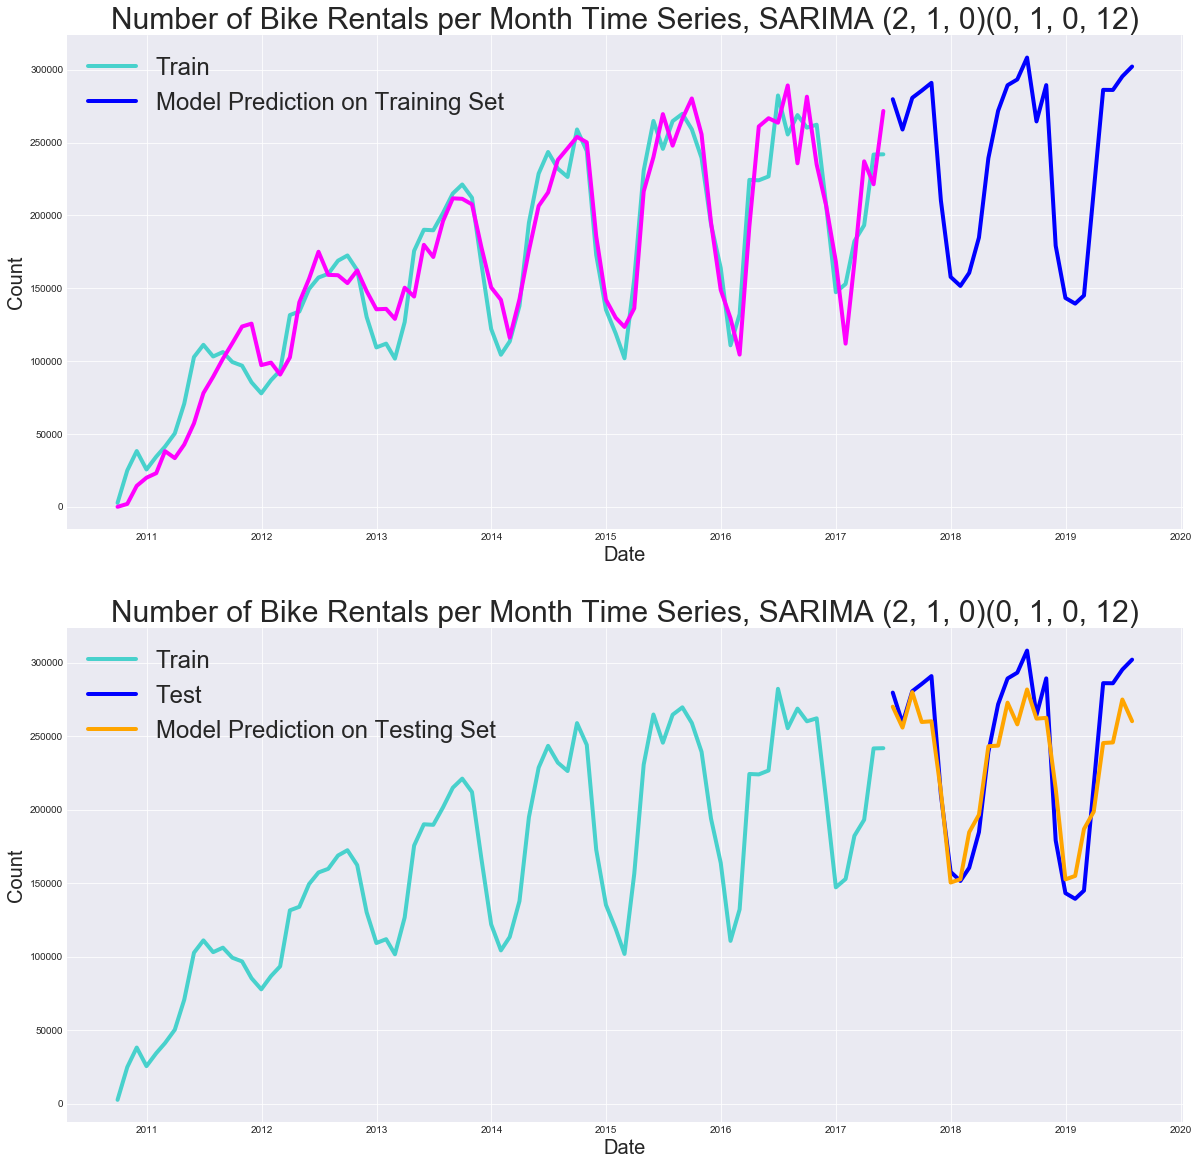

In [38]:
dt.compare_mse(best_m, bike_rental_type, test=True, return_val=False, var='member')
p.prediction_plot(best_m, bike_rental_type, orders=[(2, 1, 0),(0, 1, 0, 12)], test=True, var='member')

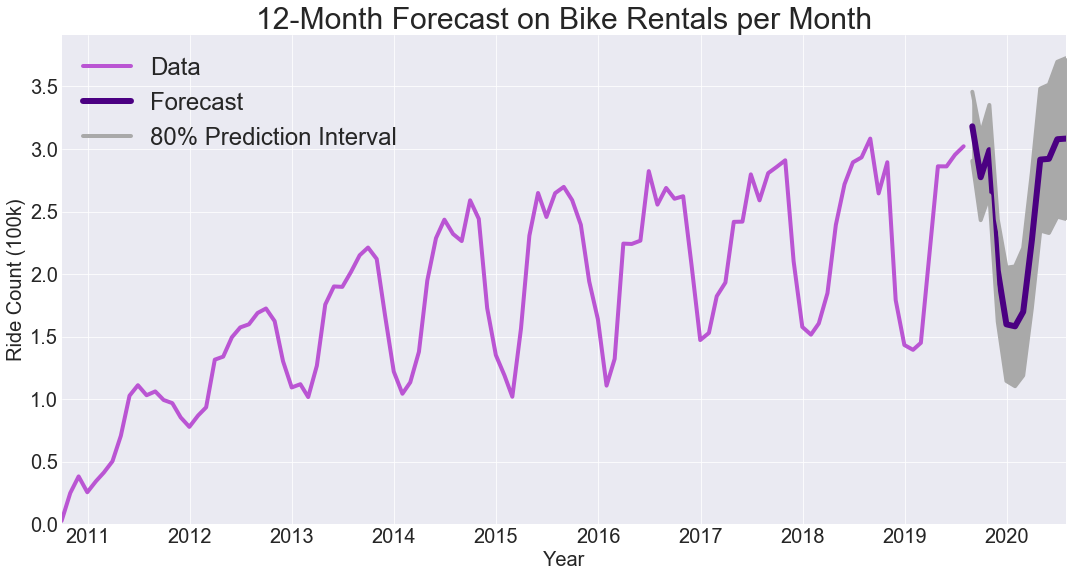

In [40]:
best_m = sm.tsa.statespace.SARIMAX(bike_rental_type['member'], trend='n',
                                 order=(2, 1, 1), seasonal_order=(2, 1, 0, 12)).fit()
p.forecast_plot(best_m, bike_rental_type, 12, var='member')

From this, we can see that although the test MSE increases slightly, we still see that the size of the confidence interval shrinks. This indicates that although the error is slightly increased, our projection has a smaller statistically-significant projection window. In addition, we can also see that our model underestimates a growth in "Member" bike rentals during the 2018 and 2019 summer months, indicating that there may still be additional factors contributing to membership bike rentals.

## Casual dataset

We will now complete the "Casual" dataset time-series. We will first determine the number of orders of differencing it requires.

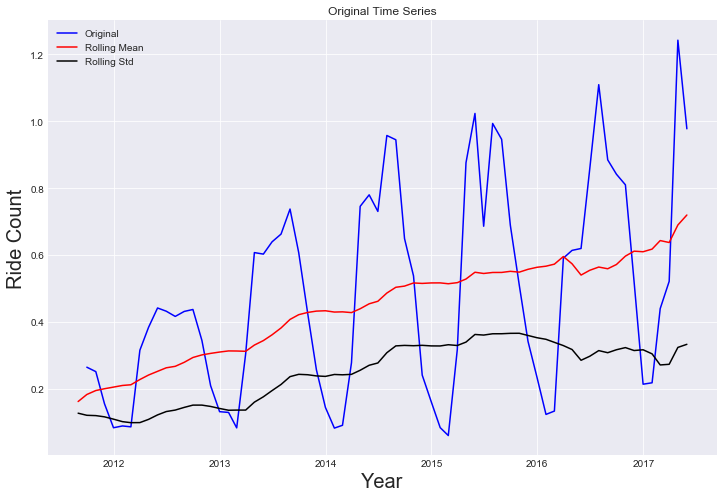

Results of Dickey-Fuller Test:
Test Statistic                 -0.442550
p-value                         0.902748
#Lags Used                     11.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64


In [41]:
dt.stationarity_test(breakdown_train, var='casual')

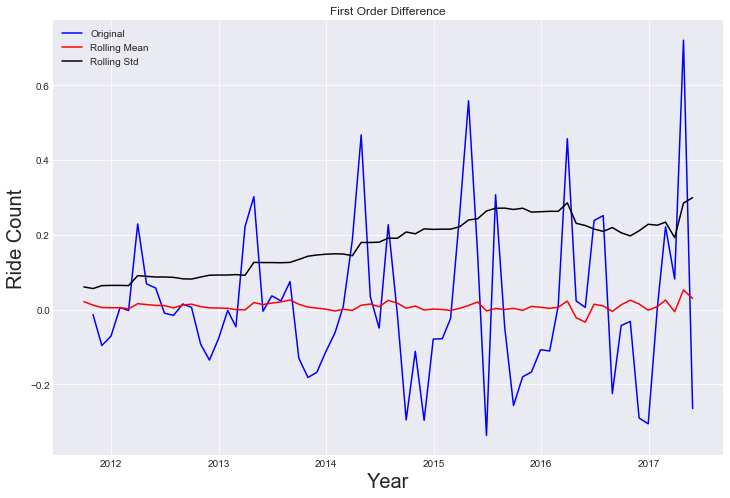

Results of Dickey-Fuller Test:
Test Statistic                -8.004774e+00
p-value                        2.283216e-12
#Lags Used                     1.000000e+01
Number of Observations Used    6.900000e+01
Critical Value (1%)           -3.528890e+00
Critical Value (5%)           -2.904440e+00
Critical Value (10%)          -2.589656e+00
dtype: float64


In [42]:
dt.stationarity_test(breakdown_train, var='casual', diff=True)

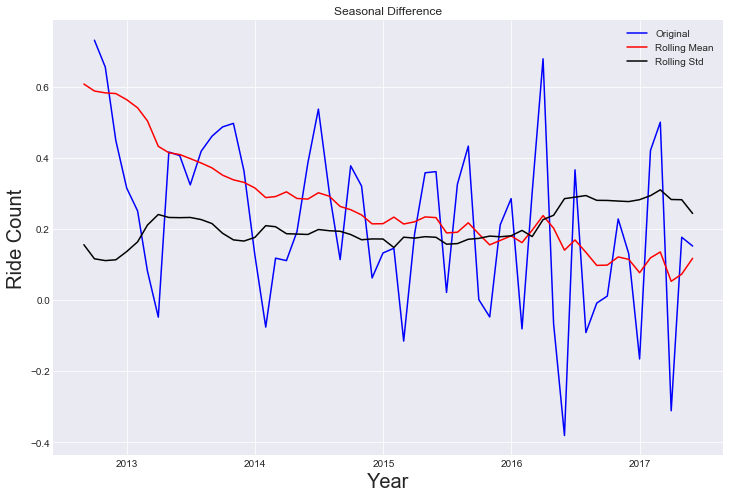

Results of Dickey-Fuller Test:
Test Statistic                 -1.810303
p-value                         0.375359
#Lags Used                      9.000000
Number of Observations Used    59.000000
Critical Value (1%)            -3.546395
Critical Value (5%)            -2.911939
Critical Value (10%)           -2.593652
dtype: float64


In [43]:
dt.stationarity_test(breakdown_train, var='member', s_diff=True)

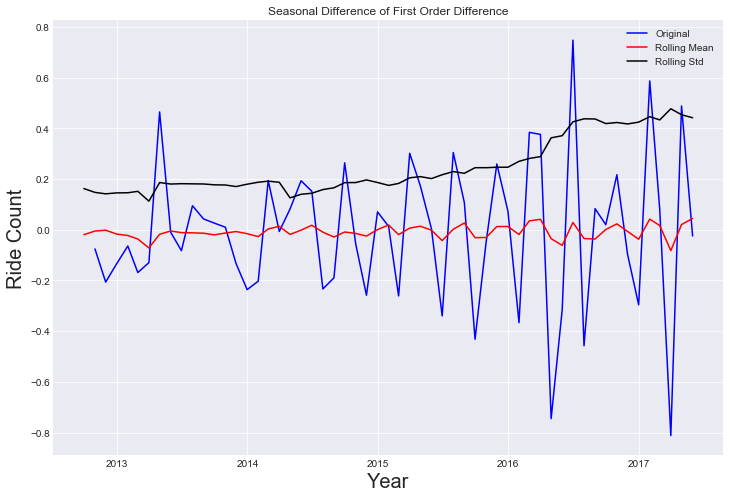

Results of Dickey-Fuller Test:
Test Statistic                -6.284988e+00
p-value                        3.716892e-08
#Lags Used                     8.000000e+00
Number of Observations Used    5.900000e+01
Critical Value (1%)           -3.546395e+00
Critical Value (5%)           -2.911939e+00
Critical Value (10%)          -2.593652e+00
dtype: float64


In [44]:
dt.stationarity_test(breakdown_train, var='member', diff=True, s_diff=True)

Like the prior model, this indicates that the "Casual" dataset requires one order of regular differencing, and one order of 12-month seasonal differencing following this differencing.

We will now look at the PACF and ACF.

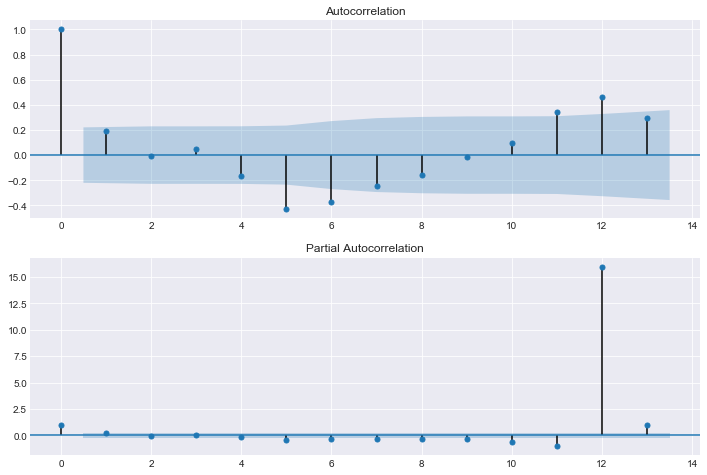

In [45]:
first = f.order_difference(breakdown_train, var='casual', diff=True, s_diff=False)
p.acf_pacf(first, var='casual')

As with the prior analysis, this dataset has a positive first difference in its PACF, indicating it will require at least one AR. However, since the autocorrelation doesn't seem to be as great, it may require fewer ARs. In addition, the positive autocorrelation surrounding the 12-month seasonal difference indicates that it will require at least one SAR as well.

In order to verify the best model, we will use the prior function to determine the optimal ARIMA and SARIMA parameters. We will test the same ARIMA/SARIMA combinations as before.

(1, 1, 0), (1, 1, 0, 12):
Training MSE:  1.95e+08
(1, 1, 0), (2, 1, 0, 12):
Training MSE:  1.94e+08
(1, 1, 0), (1, 1, 1, 12):
Training MSE:  1.94e+08
(2, 1, 0), (1, 1, 0, 12):
Training MSE:  1.77e+08
(2, 1, 0), (2, 1, 0, 12):
Training MSE:  1.77e+08
(2, 1, 0), (1, 1, 1, 12):
Training MSE:  1.77e+08
(1, 1, 1), (1, 1, 0, 12):
Training MSE:  1.63e+08
(1, 1, 1), (2, 1, 0, 12):
Training MSE:  1.63e+08
(1, 1, 1), (1, 1, 1, 12):
Training MSE:  1.63e+08
(2, 1, 1), (1, 1, 0, 12):
Training MSE:  1.77e+08
(2, 1, 1), (2, 1, 0, 12):
Training MSE:  1.77e+08
(2, 1, 1), (1, 1, 1, 12):
Training MSE:  1.77e+08
(1, 1, 2), (1, 1, 0, 12):
Training MSE:  1.66e+08
(1, 1, 2), (2, 1, 0, 12):
Training MSE:  1.66e+08
(1, 1, 2), (1, 1, 1, 12):
Training MSE:  1.66e+08
Best MSE: 1.63e+08
Best Model: (1, 1, 1), (2, 1, 0, 12)


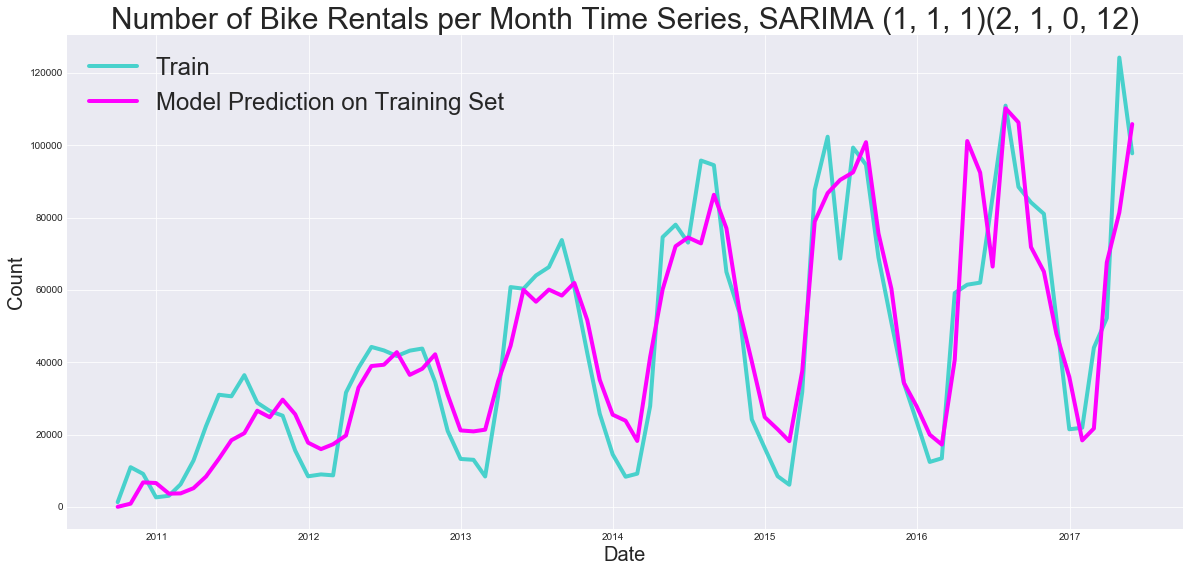

In [46]:
orders = [(1, 1, 0), (2, 1, 0), (1, 1, 1), (2, 1, 1), (1, 1, 2)]
s_orders = [(1, 1, 0, 12), (2, 1, 0, 12), (1, 1, 1, 12)]
dt.sarima(breakdown_train, orders, s_orders, var='casual')

From this, we can determine that for the "Casual" dataset, the SARIMA model that minimizes training set MSE has parameters (2, 1, 1) (2, 1, 0, 12). We will now determine whether each regulation is statistically significant, or if we will need to remove some.

In [47]:
best_c = sm.tsa.statespace.SARIMAX(breakdown_train['casual'], trend='n',
                                   order=(1, 1, 1),
                                   seasonal_order=(2, 1, 0, 12)).fit()
best_c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             casual   No. Observations:                   81
Model:             SARIMAX(1, 1, 1)x(2, 1, 0, 12)   Log Likelihood                -744.048
Date:                            Sun, 03 May 2020   AIC                           1498.096
Time:                                    17:56:28   BIC                           1509.193
Sample:                                09-30-2010   HQIC                          1502.493
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3506      0.152      2.311      0.021       0.053       0.648
ma.L1         -0.9673      0.062    -15.632      0.000      -1.089      -0.846
ar.S.L12      -0.4162      0.128     -3.251      0.001      -0.667      -0.165
ar.S.L24      -0.0092      0.332     -0.028      0.978      -0.661       0.642
sigma2      2.407e+08   8.19e-10   2.94e+17      0.000    2.41e+08    2.41e+08
===================================================================================
Ljung-Box (Q):                       37.81   Jarque-Bera (JB):                 5.92
Prob(Q):                              0.57   Prob(JB):                         0.05
Heteroskedasticity (H):               4.38   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.12e+33. Standard errors may be unstable.
"""

Based on this, we can see that we cannot prove statistical significance for the second seasonal AR, so we will remove it.

In [48]:
best_c = sm.tsa.statespace.SARIMAX(breakdown_train['casual'], trend='n',
                                   order=(1, 1, 1),
                                   seasonal_order=(1, 1, 0, 12)).fit()
best_c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             casual   No. Observations:                   81
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -744.049
Date:                            Sun, 03 May 2020   AIC                           1496.098
Time:                                    17:56:29   BIC                           1504.976
Sample:                                09-30-2010   HQIC                          1499.616
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3478      0.147      2.373      0.018       0.061       0.635
ma.L1         -0.9672      0.060    -16.074      0.000      -1.085      -0.849
ar.S.L12      -0.4143      0.127     -3.268      0.001      -0.663      -0.166
sigma2      2.407e+08    2.8e-10   8.59e+17      0.000    2.41e+08    2.41e+08
===================================================================================
Ljung-Box (Q):                       37.56   Jarque-Bera (JB):                 6.00
Prob(Q):                              0.58   Prob(JB):                         0.05
Heteroskedasticity (H):               4.40   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

We will now check the "Casual" dataset for normal distribution of residuals.

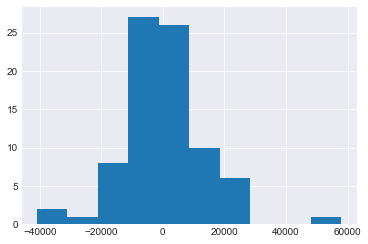

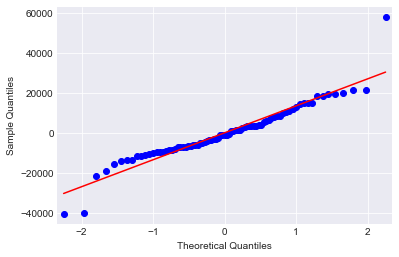

In [49]:
best_c = sm.tsa.statespace.SARIMAX(breakdown_train['casual'], trend='n',
                                   order=(1, 1, 1),
                                   seasonal_order=(0, 1, 0, 12)).fit()
best_c.resid.hist()
qqplot(best_c.resid, line='s');

For the most part, the residuals are normal. However, we can see that the residuals has some strong positive and negative values that break the normality a little. We don't want to alter these, because it may affect our prediction efficacy. However, the outliers may slightly affect our ability to model the time series.

We will now determine the test MSE, and create a prediction with a confidence interval.

Training MSE:  1.82e+08
Testing MSE:  1.65e+09


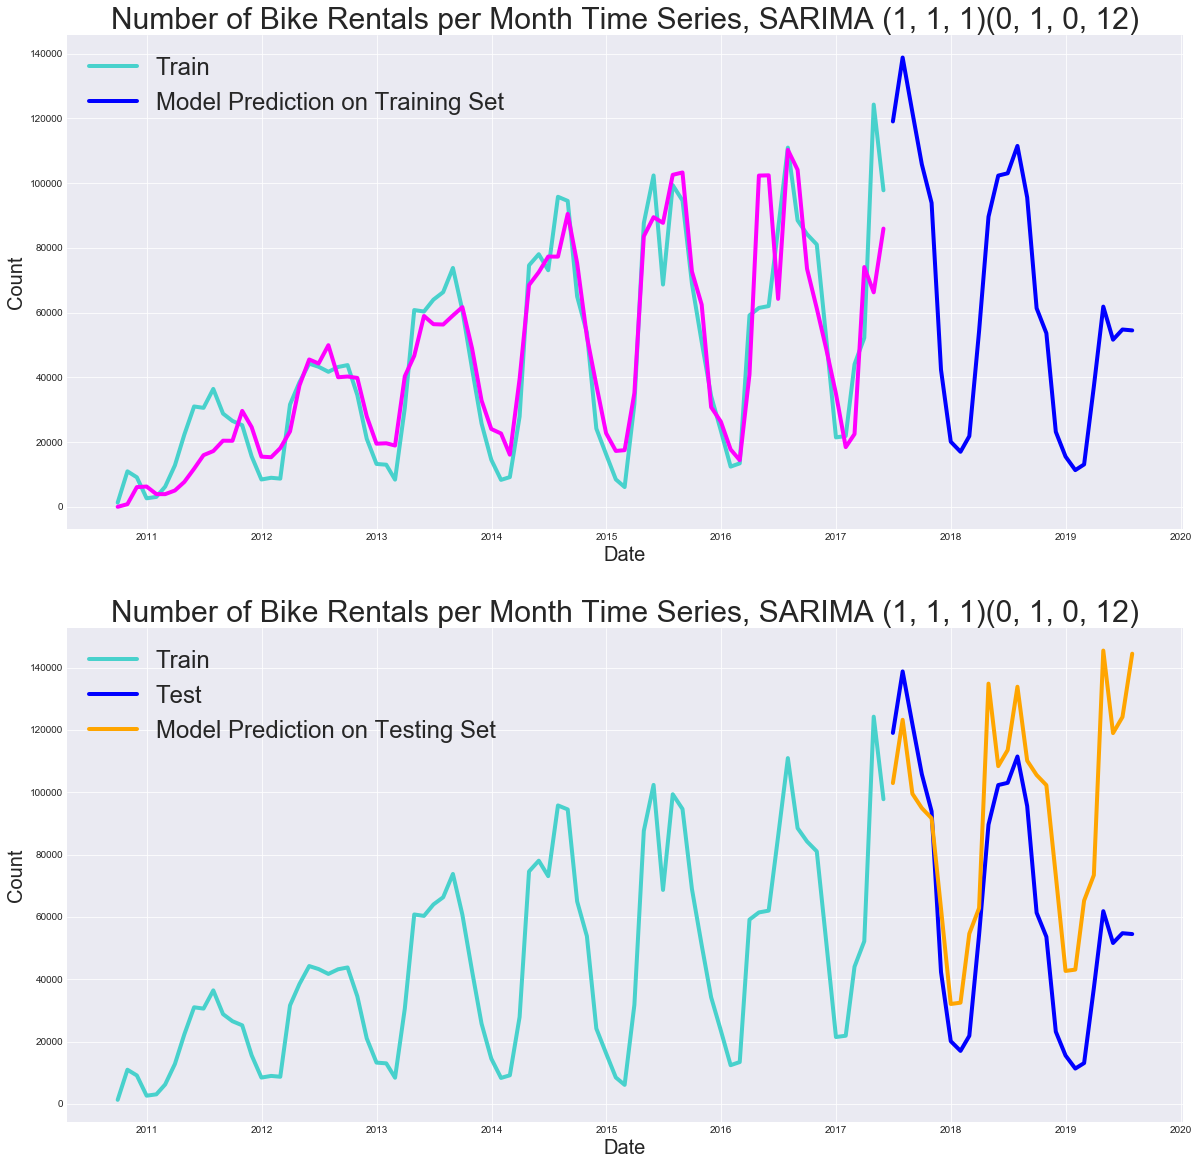

In [51]:
dt.compare_mse(best_c, bike_rental_type, test=True, return_val=False, var='casual')
p.prediction_plot(best_c, bike_rental_type, orders=[(1, 1, 1),(0, 1, 0, 12)], test=True, var='casual')

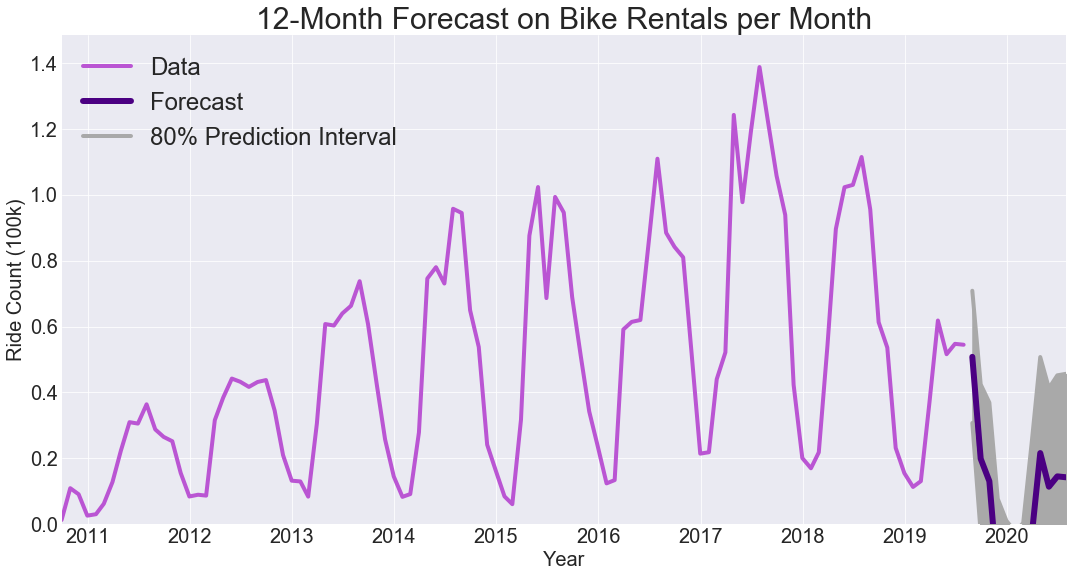

In [52]:
best_c = sm.tsa.statespace.SARIMAX(bike_rental_type['casual'], trend='n',
                                 order=(1, 1, 1), seasonal_order=(0, 1, 0, 12)).fit()
p.forecast_plot(best_c, bike_rental_type, 12, var='casual')

Based on this, we can see that although the MSE decreases from the total dataset, the prediction is heavily affected by an unforseen dip in rentals during the summer of 2019. This may be due to a number of factors, including the introduction of transportation alternatives, such as scooters. This renders our 'casual biker' prediction unusable, because it results in impossible negative predictions.

As you can see, the p-values of both are very low, indicating a close correlation between the models and the actual data. In addition, we can see a very clear difference in volume between member and casual rentals.

For comparison, we will now plot the two datasets together, along with forecasts.

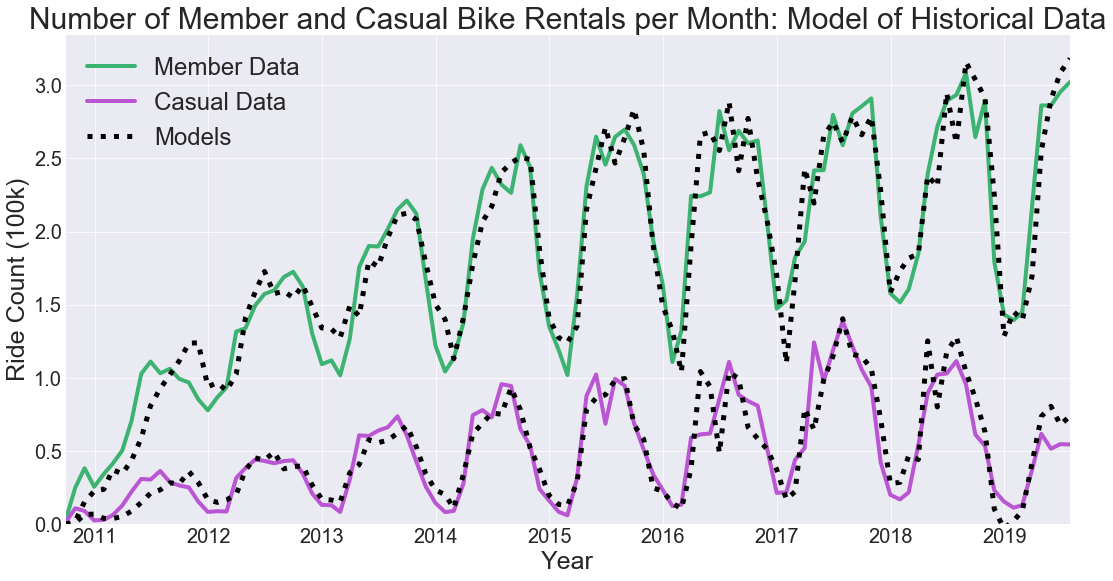

In [53]:
best_c = sm.tsa.statespace.SARIMAX(bike_rental_type['casual'], order=(1, 1, 1),
                                   seasonal_order=(0, 1, 0, 12)).fit()
best_m = sm.tsa.statespace.SARIMAX(bike_rental_type['member'], order=(2, 1, 0),
                                   seasonal_order=(0, 1, 0, 12)).fit()
p.model_plot_breakdown_both(
    best_m, best_c, bike_rental_type)

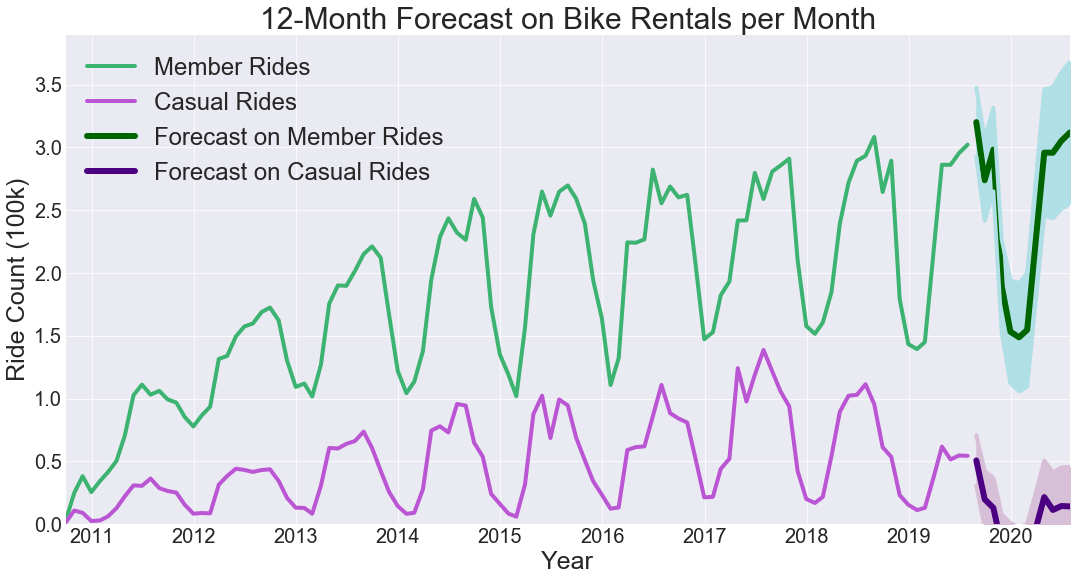

In [54]:
p.forecast_plot_breakdown_both(
    best_m, best_c, bike_rental_type, 12)

As we can see, the size of the prediction interval shrinks for the member rentals, and the prediction appears to level out. This indicates that, while the usage is not projected to increase  substantially for members, it is not projected to decrease  substantially either. However, for the casual riders, we see that the predicted usage drops below zero. This is an indicator that the time series, as it is, is still too random to provide stable predictions for this part of the dataset. The industry for casual usage, however, does appear to be in decline.

Based on this prediction, since bicycle usage is not projected to increase substantially in the next year, we can determine that Capital Bikeshare has a sufficient number of bicycles to operate over the next 12 months.